In [22]:
import types

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.metrics import r2_score, mean_squared_error

PATH_REG_TRAIN = "./bitrate_prediction/bitrate_train.csv"
PATH_REG_TEST = "./bitrate_prediction/bitrate_test.csv"
PATH_CLASS_TRAIN = "./stream_quality_data/train_data.csv"
PATH_CLASS_TEST = "./stream_quality_data/test_data.csv"

RANDOM_STATE = 319

x_train_c = pd.read_csv(PATH_CLASS_TRAIN)
x_test_c = pd.read_csv(PATH_CLASS_TEST)
x_train_r = pd.read_csv(PATH_REG_TRAIN)
x_test_r = pd.read_csv(PATH_REG_TEST)

In [23]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred):
    fig, ax = plt.subplots()
    cm = confusion_matrix(y_true, y_pred)
    fig.set_size_inches((4,4))
    ax.imshow(cm, cmap="gray")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="red")
    plt.show()

In [79]:
def plot_dataset(ds, labels, model = False, alpha = 0.005):
    if model:
        x_dummy = np.arange(-2, 5, 0.1)

    rows = ds.shape[1]//2+1
    fig, ax = plt.subplots(rows, 3)
    fig.set_size_inches(12,4 * rows)
    for i in range(0, ds.shape[1], 2):
        row = i//2
        ax[row, 0].scatter(ds.iloc[:,i], ds.iloc[:,i+1], alpha=alpha)
        ax[row, 0].axvline(np.mean(ds.iloc[:,i]), c = 'red')
        ax[row, 0].axhline(np.mean(ds.iloc[:,i+1]), c = 'red')
        ax[row, 0].set_title(f'{ds.columns[i]} | {ds.columns[i+1]}')

        ax[row, 1].scatter(ds.iloc[:,i], labels, alpha=alpha)
        ax[row, 1].axvline(np.mean(ds.iloc[:,i]), c = 'red')
        ax[row, 1].set_title(f'{ds.columns[i]} | target')

        ax[row, 2].scatter(ds.iloc[:,i+1], labels, alpha=alpha)
        ax[row, 2].axvline(np.mean(ds.iloc[:,i+1]), c = 'red')
        ax[row, 2].set_title(f'{ds.columns[i+1]} | target')

    if ds.shape[1]//2 == 1:
        ax[ds.shape[1]//2, 0].scatter(ds.iloc[:,-1], labels, alpha=alpha)
        ax[ds.shape[1]//2, 0].set_title(f'{ds.columns[-1]} | target')
    plt.show()


def plot_boxplots(ds):
    fig, ax = plt.subplots(ds.shape[1]//3 + int(ds.shape[1]%3!=0), 3)

    fig.set_size_inches(12,12)

    for i, n in enumerate(ds.columns):
        ax[i//3, i%3].boxplot(ds[n])
        ax[i//3, i%3].set_title(n)

def evaluate_model(model, x_train, y_train, x_test=False, y_test=False, metrics={"r2_score" : r2_score, "mse" : mean_squared_error}, fit_model = False):
    if type(y_test) == bool:
        x_test = x_train
        y_test = y_train

    if fit_model:
        model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    scores = {}

    for t in metrics.keys():
        scores.update({t : metrics[t](y_test, y_pred)})

    return scores, model, y_pred


from sklearn.linear_model import LinearRegression
class Polynomial:
    def __init__(self, degree=2, model=LinearRegression()):
        self.degree=degree
        self.model = model

    def fit(self, X, y):
        self.poly_transform = PolynomialFeatures(self.degree).fit(X)
        self.model.fit(self.poly_transform.transform(X), y)

    def predict(self, X):
        return self.model.predict(self.poly_transform.transform(X))


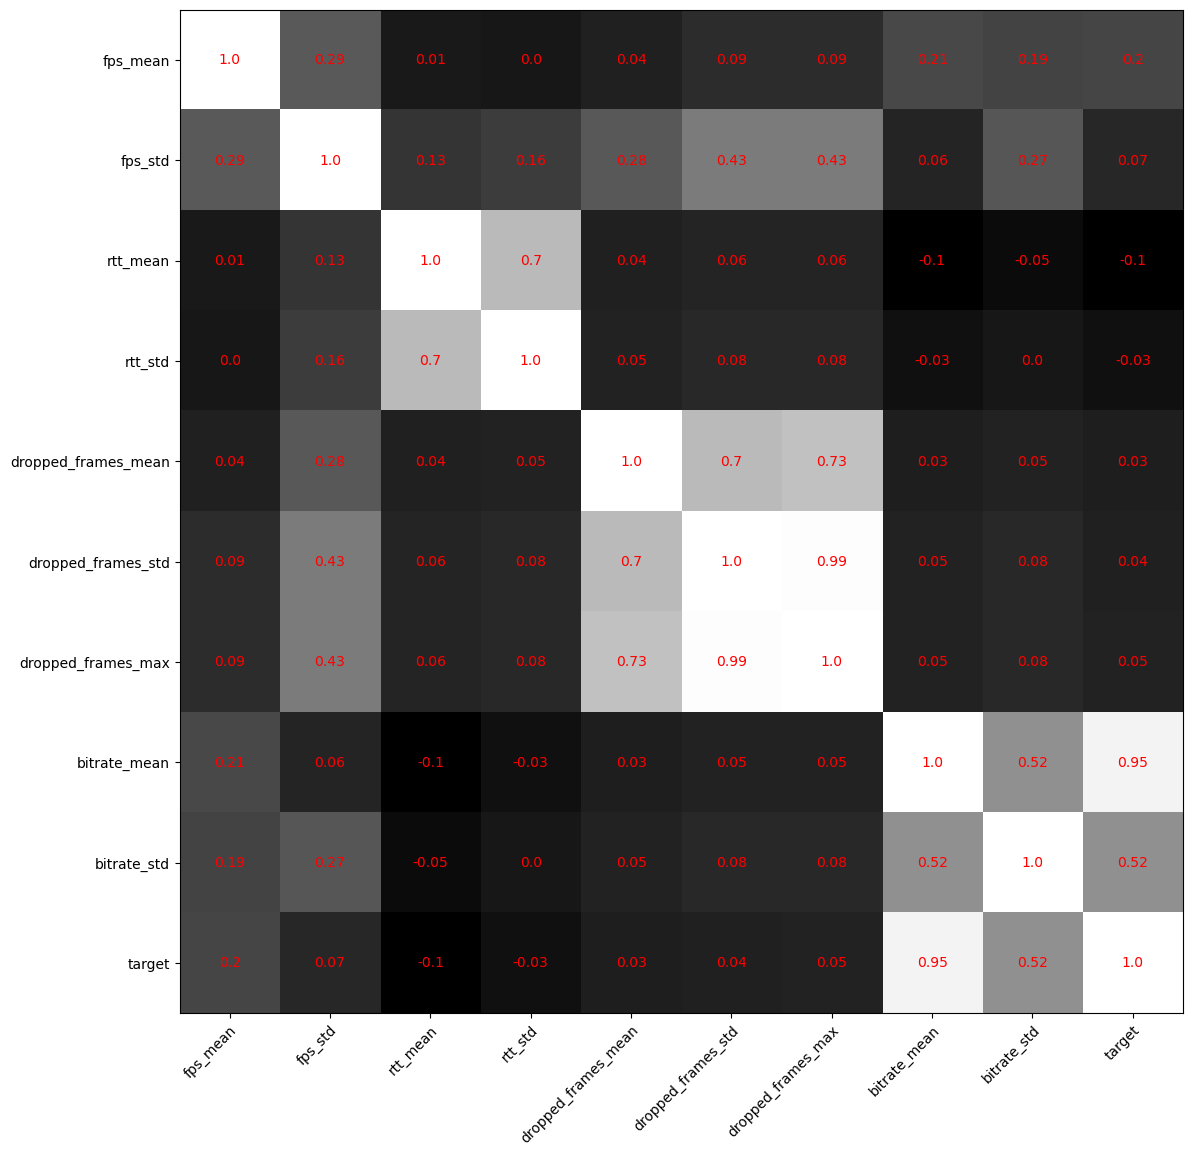

In [25]:
def show_corr(ds):
    cols = ds.columns
    data = np.round(ds.corr(),2)


    fig, ax = plt.subplots()
    fig.set_size_inches((12,12))
    ax.imshow(data, cmap="gray")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(cols)), labels=cols)
    ax.set_yticks(np.arange(len(cols)), labels=cols)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(cols)):
        for j in range(len(cols)):
            text = ax.text(j, i, data.iloc[i, j],
                           ha="center", va="center", color="red")

    fig.tight_layout()
    plt.show()

show_corr(x_train_r)

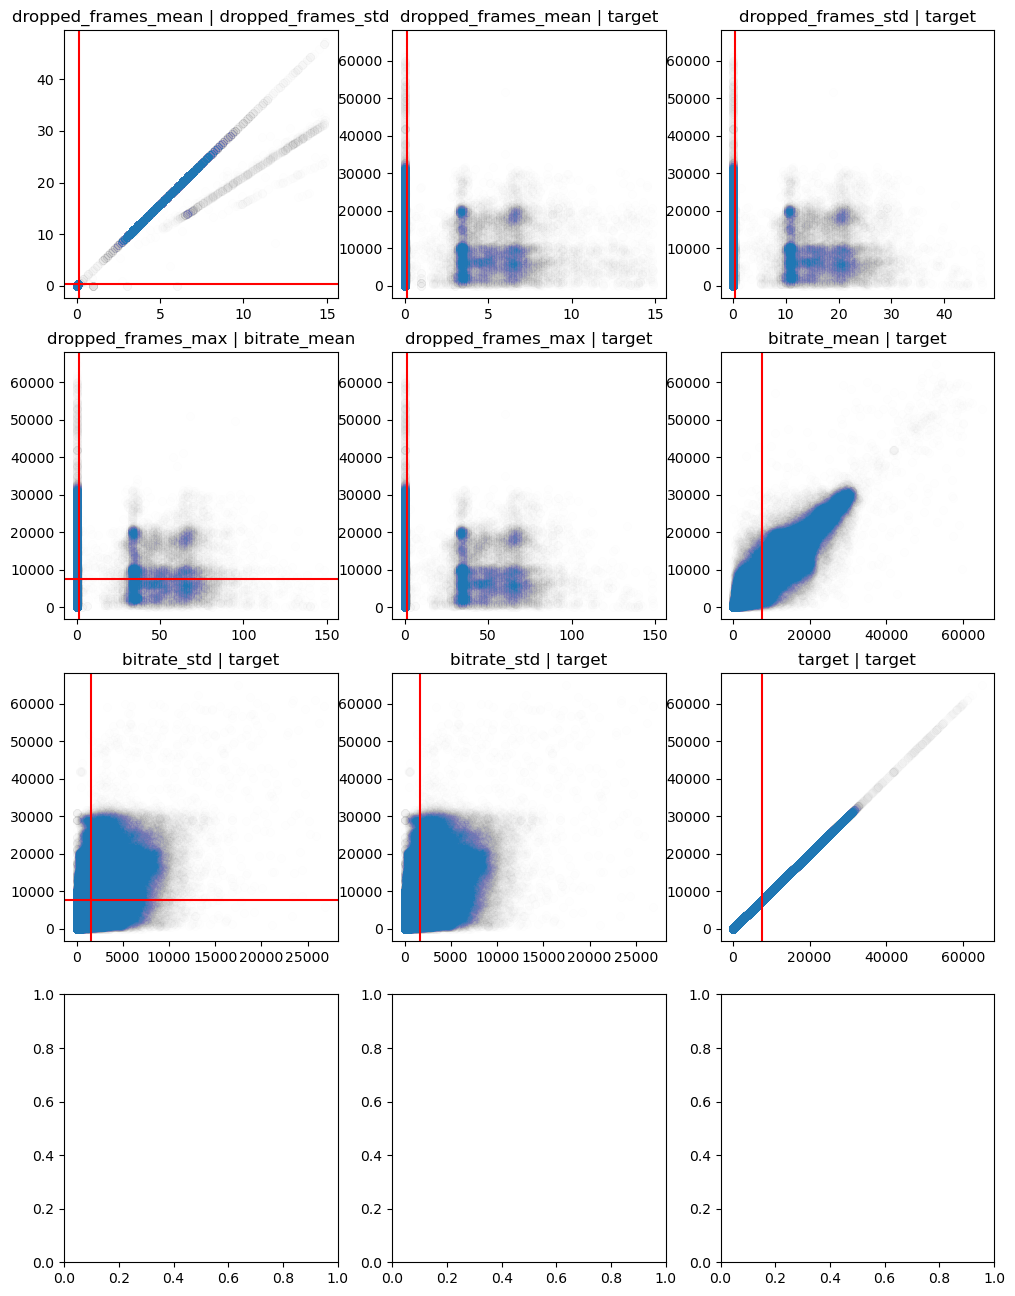

In [26]:
x_train_general = x_train_r.copy()
x_train_general = x_train_general.loc[x_train_general["dropped_frames_mean"] < 15]
plot_dataset(x_train_general.iloc[:,4:], x_train_general["target"], alpha=0.005)

In [27]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = None
def reg_pipe(X_: pd.DataFrame, y: pd.Series = False, fit_mode = False)->pd.DataFrame:
    X = X_.copy()

    X.drop(["bitrate_mean", "bitrate_std"], inplace=True, axis=1)

    X.drop(["dropped_frames_std", 'dropped_frames_max'], inplace=True, axis=1)
    X['dropped_frames_occured'] = X['dropped_frames_mean'].apply(lambda x: np.int8(x>0))
    #X['fps_std'] = X['fps_std'].apply(lambda x: x>6)
    X['fps_unstable'] = X['fps_std'].apply(lambda x: x>5)
    X['fps_highly_unstable'] = X['fps_std'].apply(lambda x: x>15)
    X["fps_std"] = X["fps_std"].apply(lambda x: np.log(x) if x>2 else x)
    X['rtt_unstable'] = X['rtt_std'].apply(lambda x: x>5)
    #X['rtt_std'] = X['rtt_std'].apply(lambda x: np.log(x) if x>2 else x)
    X['fps_anomaly'] = X['fps_mean'].apply(lambda x: not (x>25 and x<35))
    X['rtt_anomaly'] = X['rtt_mean'].apply(lambda x: x>50)
    X.drop(["dropped_frames_mean"], axis=1, inplace=True)


    if fit_mode:
        X["target"] = y
        X.drop_duplicates(inplace = True)
        #X = X.loc[X["rtt_std"] < 50]
        X = X.loc[X["rtt_mean"] < 70]
        X = X.loc[(X["fps_mean"] < 70)]
        #X = X.loc[(X["dropped_frames_mean"] < 10)]
        X = X.loc[(X["fps_std"] < 20)]
        X = X.loc[(X["target"] < 21000) ]
        #X.drop(["rtt_mean", "rtt_std"], axis = 1, inplace = True)


    if "target" in X.columns:
        y = X["target"]
        X = X.drop("target", axis=1)

    global scaler
    if fit_mode:
        scaler = MinMaxScaler().fit(X)

    X = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)

    # X = X.apply(lambda x: x - np.mean(x), axis=1)
    print(X.shape)
    if type(y) != bool:
        return X, y
    return X


In [28]:
x_train_r_no_target = x_train_r.drop(["target"], axis=1)
x_train_piped, y_train = reg_pipe(x_train_r_no_target, x_train_r["target"], fit_mode=True)

(296761, 10)


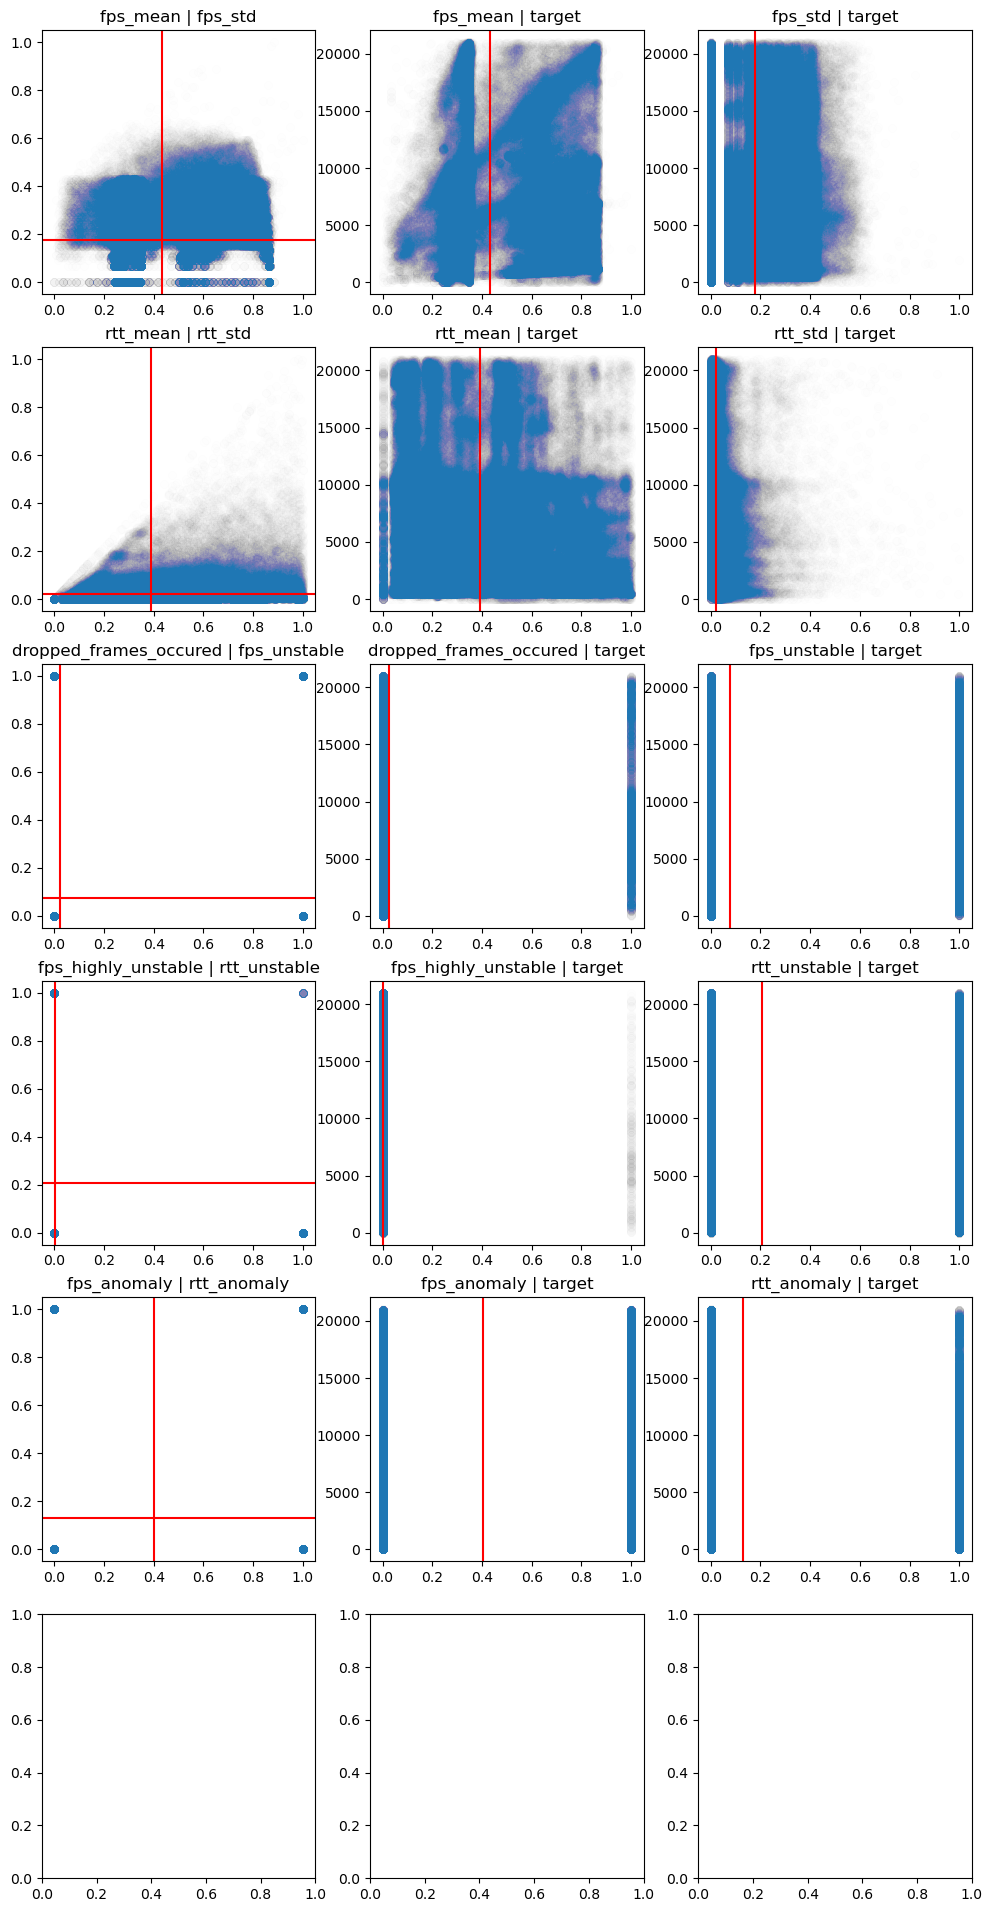

In [29]:

plot_dataset(x_train_piped, y_train, None, alpha = 0.002)

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

model = LinearRegression(fit_intercept=True).fit(x_train_piped, y_train)
y_train_pred_r = model.predict(x_train_piped)
print(r2_score(y_train, y_train_pred_r))
print(np.sqrt(mean_squared_error(y_train, y_train_pred_r)))

0.07202353282867568
5033.475966677223


In [31]:
x_train_piped.describe()

,fps_mean,fps_std,rtt_mean,rtt_std,dropped_frames_occured,fps_unstable,fps_highly_unstable,rtt_unstable,fps_anomaly,rtt_anomaly
count,296761.000000,296761.000000,296761.000000,296761.000000,296761.000000,296761.000000,296761.000000,296761.000000,296761.000000,296761.00000
mean,0.432889,0.178215,0.390376,0.022345,0.024312,0.075687,0.001917,0.206318,0.402327,0.13121
std,0.184711,0.141841,0.251126,0.048003,0.154018,0.264497,0.043746,0.404662,0.490368,0.33763
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.328720,0.068191,0.181688,0.003321,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.346021,0.172081,0.354793,0.006330,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,0.569204,0.284199,0.563662,0.018762,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


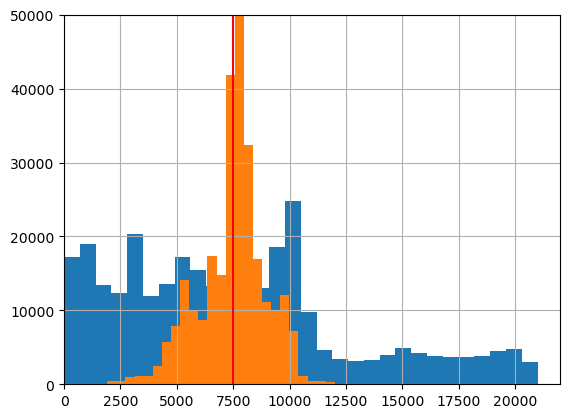

In [32]:
y_train.hist(bins=30)
pd.Series(y_train_pred_r).hist(bins=30)
plt.axvline(np.mean(y_train), c = "red")
plt.ylim([0, 50000])
plt.xlim([0, 22000])
plt.show()

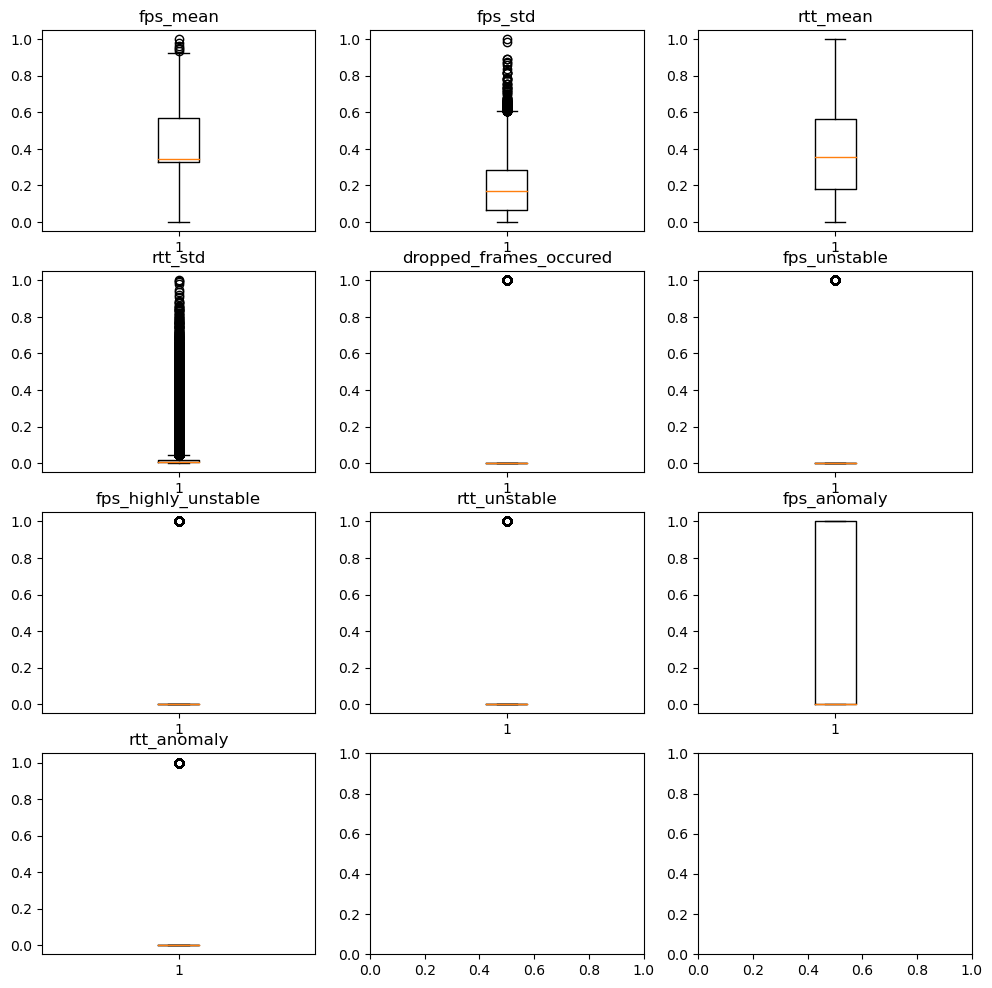

In [33]:
plot_boxplots(x_train_piped)

In [34]:
pd.DataFrame(model.coef_, x_train_piped.columns)

,0
fps_mean,7541.928780
fps_std,2558.622407
rtt_mean,-712.120614
rtt_std,3534.899385
dropped_frames_occured,1944.035256
fps_unstable,-462.754859
fps_highly_unstable,-1134.564149
rtt_unstable,-1210.345404
fps_anomaly,-1711.448968
rtt_anomaly,-1709.939394


In [35]:
from pandas_profiling import ProfileReport
import yaml

report = ProfileReport(x_train_r)
#report.to_file("./Profile.html")

In [36]:
from sklearn.decomposition import PCA

pca = PCA(2).fit(x_train_piped)
x_train_pca = pca.transform(x_train_piped)
#x_train_pca = np.array(list(map(lambda x: min(x[0], 2), x_train_pca)))

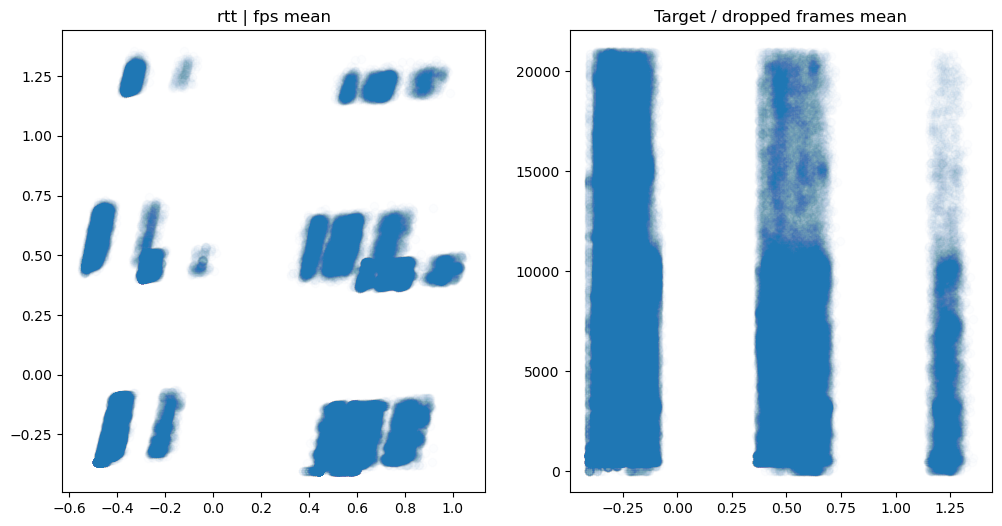

In [37]:
plt.show()
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 6)

ax[0].scatter(x_train_pca[:,0], x_train_pca[:,1], alpha = 0.01)
ax[0].set_title("rtt | fps mean")
#ax[0].set_ylim([-4, 4])
#ax[0].set_xlim([-3, 4])
ax[1].scatter(x_train_pca[:,1], y_train, alpha = 0.01)
ax[1].set_title("Target / dropped frames mean")
#ax[1].set_xlim([-3, 10])
plt.show()

In [38]:
model_pca = LinearRegression(fit_intercept=True).fit(x_train_pca, y_train)
y_train_pred_r = model_pca.predict(x_train_pca)
print(r2_score(y_train, y_train_pred_r))

0.021284951463569124


In [39]:
x_train_raw = x_train_r.drop(["bitrate_std", "bitrate_mean", "target"], axis=1)
y_train_raw = x_train_r["target"]
model_raw = LinearRegression().fit(x_train_raw, y_train_raw)
y_train_raw_pred = model_raw.predict(x_train_raw)

print(r2_score(y_train_raw, y_train_raw_pred))
print(np.sqrt(mean_squared_error(y_train_raw, y_train_raw_pred)))

0.055081229609200144
5901.247906753912


In [40]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures

metrics = [r2_score, lambda x, y: mean_squared_error(x, y, squared=False)]
models = [LinearRegression(),
          Ridge(1),
          Lasso(1),
          Polynomial(2),
          Polynomial(3)]

poly_degree=2
poly_transform = PolynomialFeatures(poly_degree).fit(x_train_piped)

x_train_piped, y_train = reg_pipe(x_train_r.drop("target", axis=1), x_train_r["target"])
for n in models:
    print(evaluate_model(n, x_train_piped, y_train, metrics=metrics)[0])
#x_train_poly = poly_transform.transform(x_train_piped)
#print(evaluate_model(LinearRegression(), x_train_poly, y_train, metrics=metrics)[0])
#print(evaluate_model(Ridge(), x_train_poly, y_train, metrics=metrics)[0])

x_test_piped, y_test = reg_pipe(x_test_r.drop("target", axis=1), x_test_r["target"])
for n in models:
    print(evaluate_model(n, x_train_piped, y_train, x_test_piped, y_test,metrics=metrics)[0])
#x_test_poly = poly_transform.transform(x_test_piped)
#print(evaluate_model(LinearRegression(), x_train_poly, y_train, x_test_poly, y_test, metrics=metrics)[0])
#print(evaluate_model(Ridge(), x_train_poly, y_train, x_test_poly, y_test, metrics=metrics)[0])


(379021, 10)


NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [41]:
x_test_piped

NameError: name 'x_test_piped' is not defined

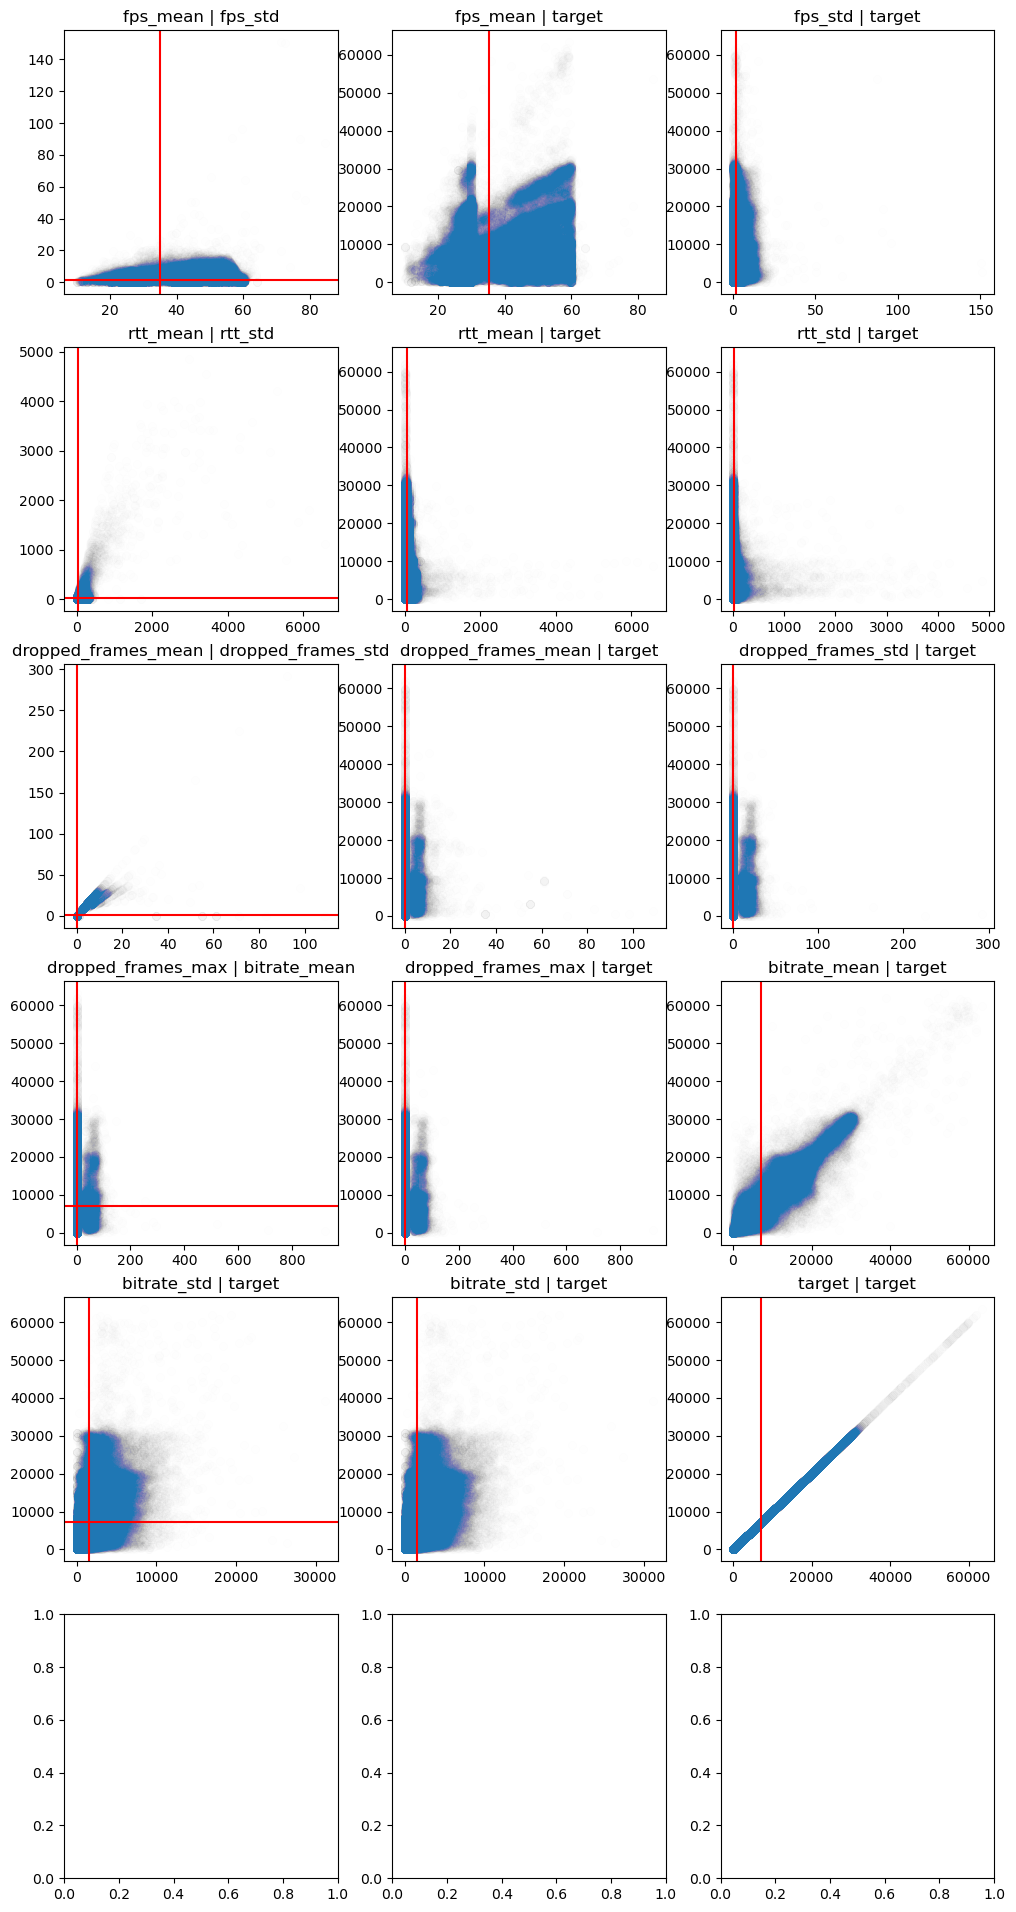

In [42]:
plot_dataset(x_test_r,x_test_r["target"], alpha=0.002)

###Classification




In [43]:
x_train_c_embbedded = x_train_c.copy()
x_train_c_embbedded["auto_bitrate_state"] = x_train_c_embbedded["auto_bitrate_state"].apply(lambda x: x!="off")
x_train_c_embbedded["auto_fec_state"] = x_train_c_embbedded["auto_fec_state"].apply(lambda x: x!="off")
x_train_c_embbedded

,fps_mean,fps_std,fps_lags,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,auto_bitrate_state,auto_fec_state,auto_fec_mean,stream_quality
0,24.4,0.516398,0,91.1,6.723921,0.0,0.0,0.0,False,True,50.0,0
1,28.6,2.065591,0,99.7,15.923777,0.0,0.0,0.0,False,True,50.0,0
2,30.0,0.000000,0,98.1,11.798776,0.0,0.0,0.0,False,True,50.0,0
3,30.3,0.948683,0,99.4,13.014522,0.0,0.0,0.0,False,True,50.0,0
4,29.9,0.316228,0,123.2,62.476307,0.0,0.0,0.0,False,True,50.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
406567,40.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0,True,True,50.0,0
406568,40.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0,True,True,50.0,0
406569,40.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0,True,True,50.0,0
406570,40.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0,True,True,50.0,0


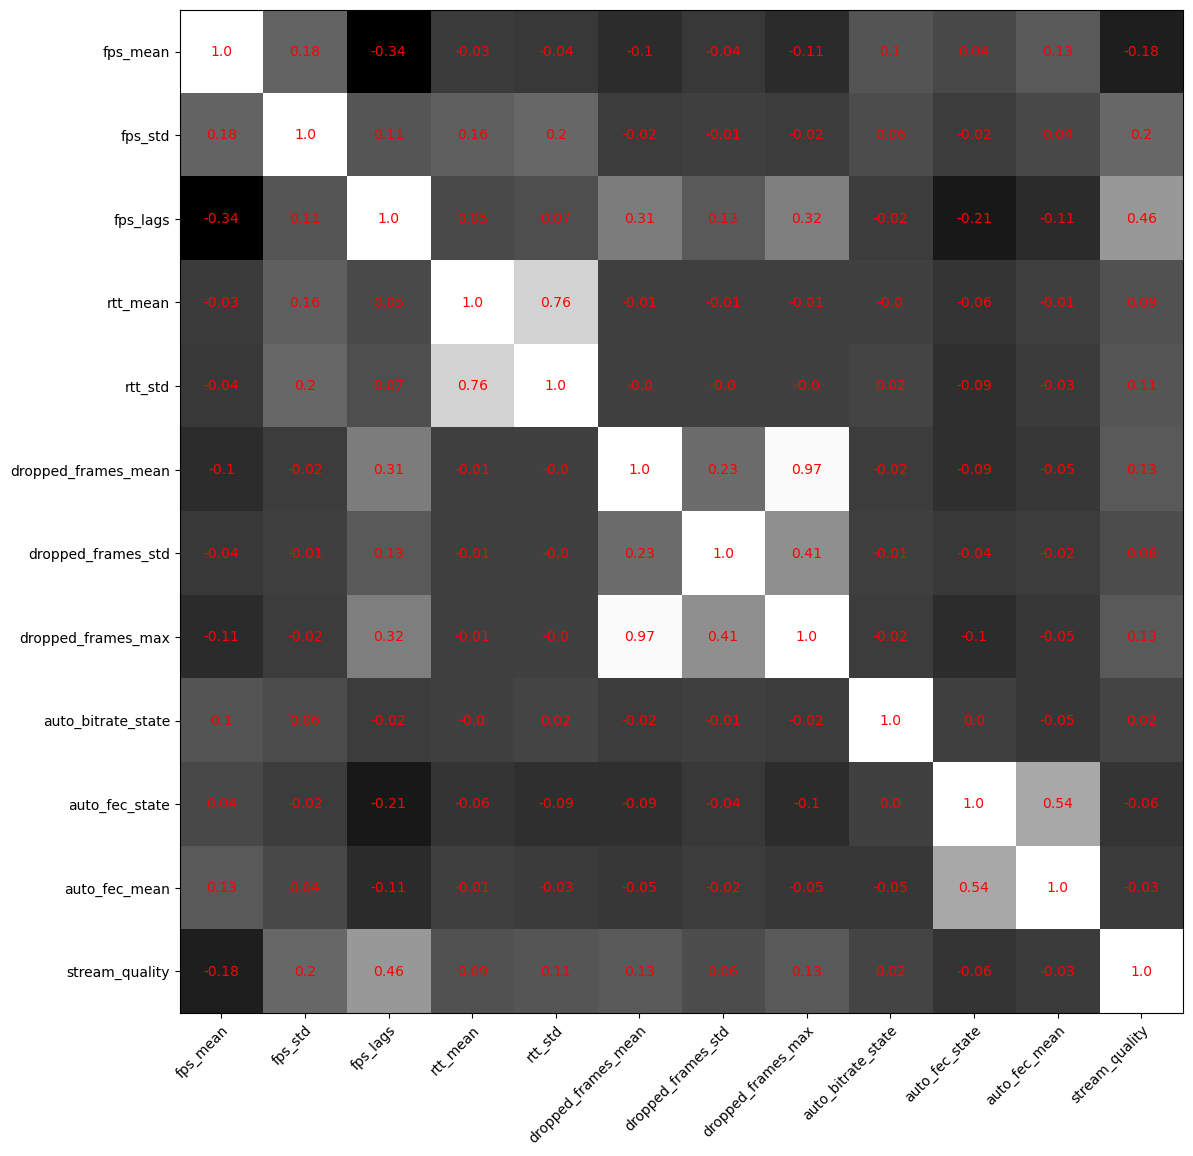

In [44]:
show_corr(x_train_c_embbedded)

(406572, 12)
(381533, 12)


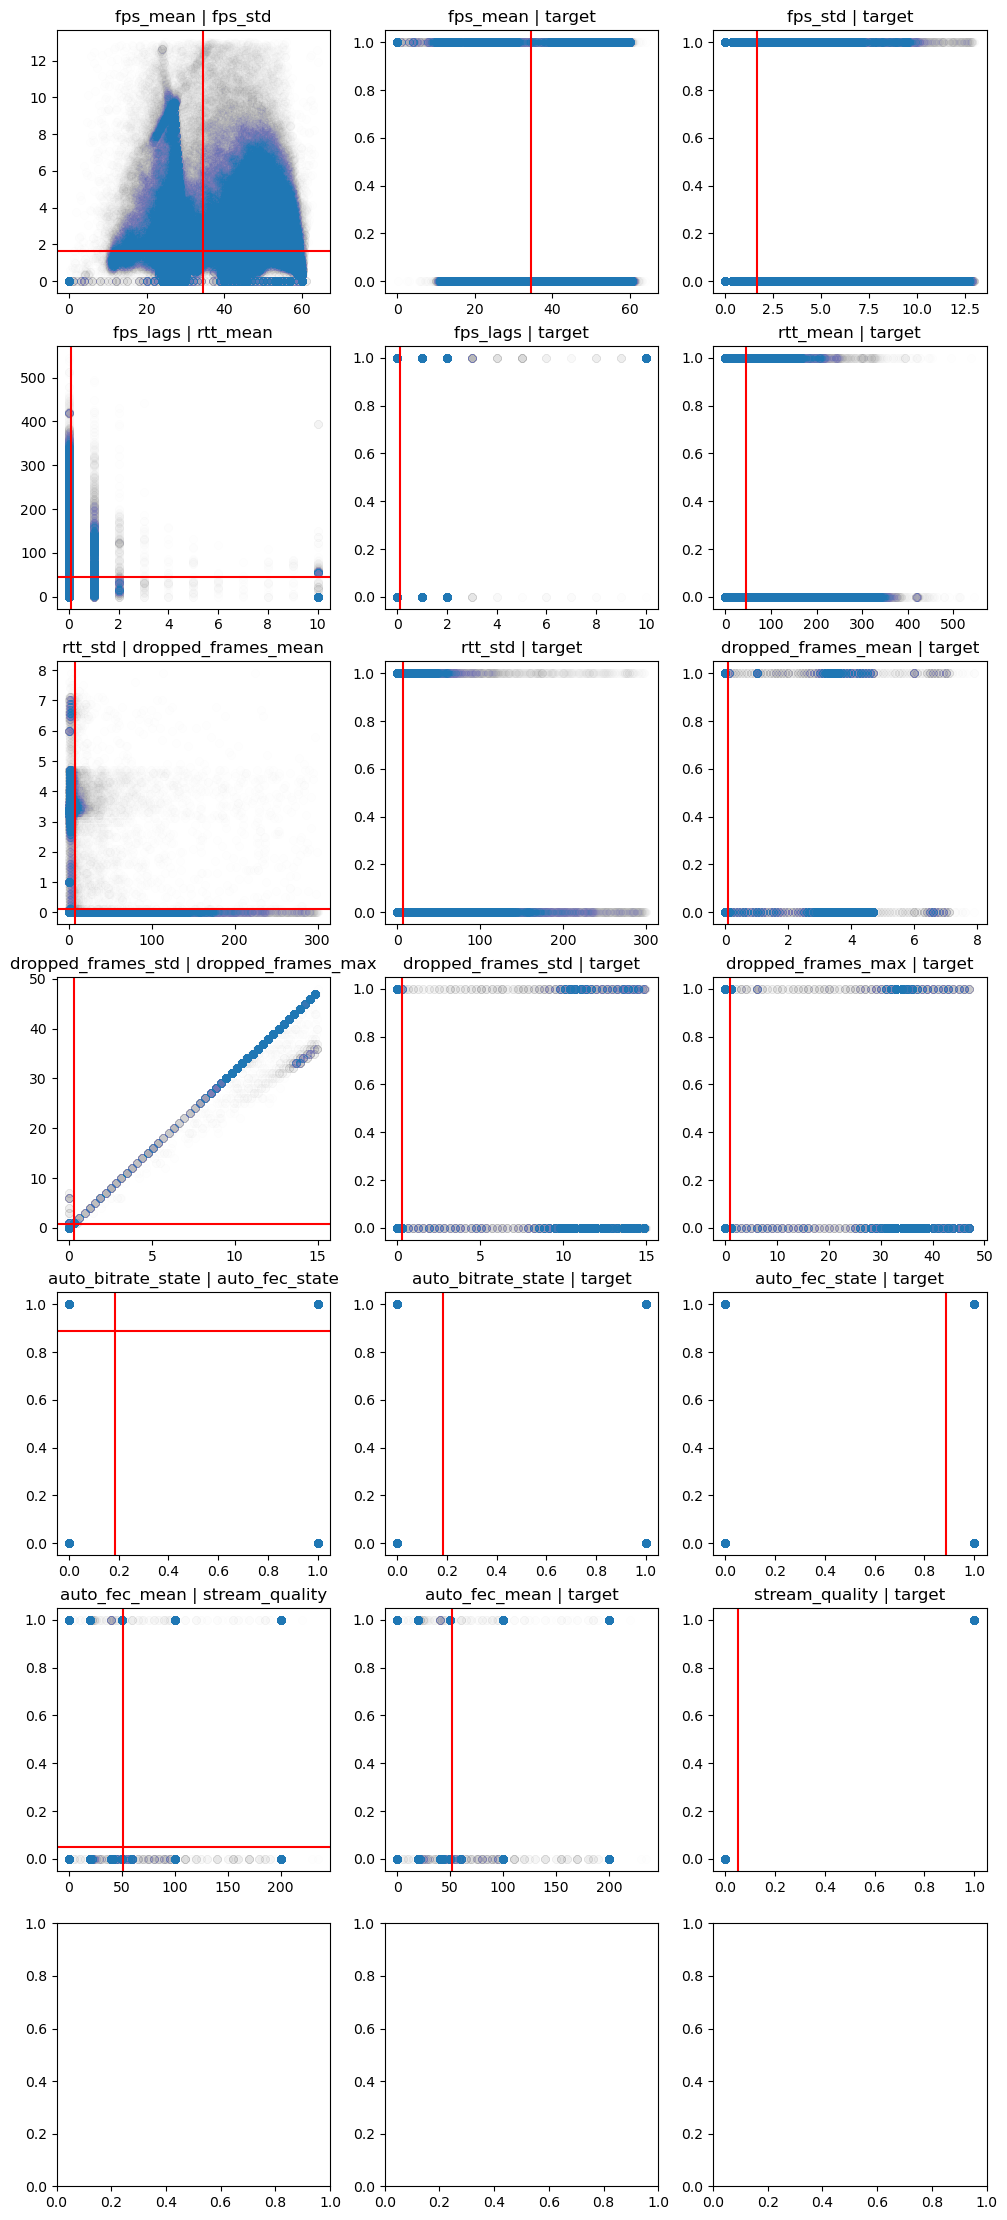

In [45]:
print(x_train_c_embbedded.shape)
x_train_c_cleared = x_train_c_embbedded.copy()
x_train_c_cleared = x_train_c_cleared.loc[x_train_c_cleared["fps_std"] < 13]
x_train_c_cleared = x_train_c_cleared.loc[x_train_c_cleared["fps_mean"] < 65]
x_train_c_cleared = x_train_c_cleared.loc[x_train_c_cleared["rtt_mean"] < 600]
x_train_c_cleared = x_train_c_cleared.loc[x_train_c_cleared["dropped_frames_mean"] < 8]
x_train_c_cleared = x_train_c_cleared.loc[x_train_c_cleared["rtt_std"] < 300]
x_train_c_cleared = x_train_c_cleared.loc[x_train_c_cleared["dropped_frames_std"] < 15]
x_train_c_cleared = x_train_c_cleared.loc[x_train_c_cleared["dropped_frames_max"] < 50]

print(x_train_c_cleared.shape)
plot_dataset(x_train_c_cleared, x_train_c_cleared["stream_quality"])

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

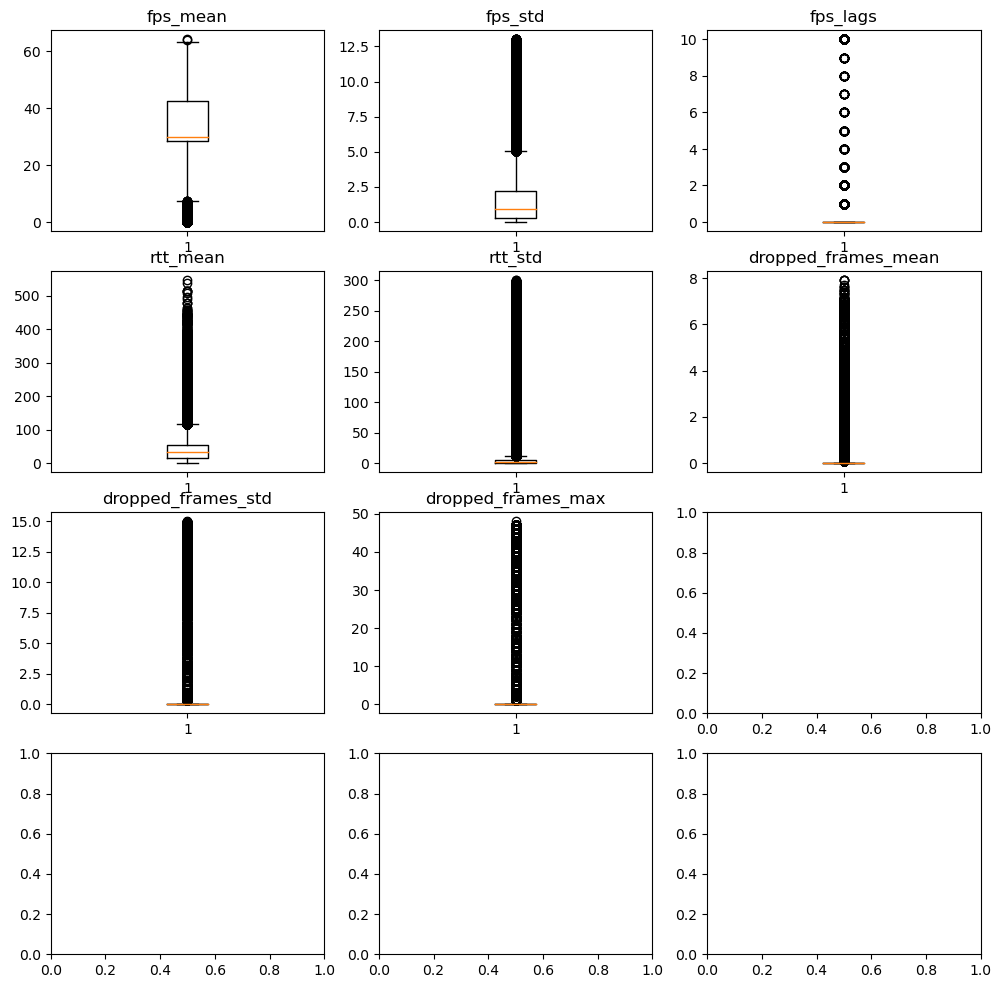

In [46]:
plot_boxplots(x_train_c_cleared)

0    378738
1     27834
Name: stream_quality, dtype: int64


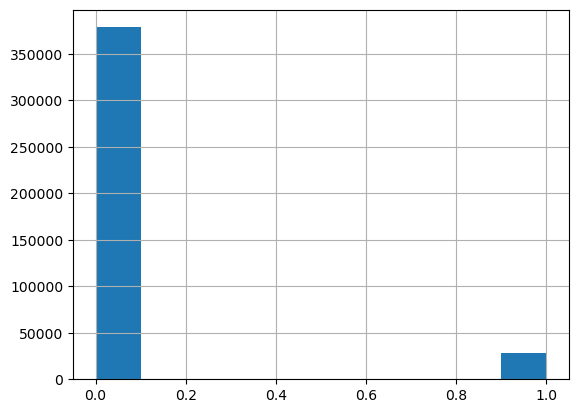

In [47]:
print(x_train_c_embbedded["stream_quality"].value_counts())
x_train_c_embbedded["stream_quality"].hist()
plt.show()

In [48]:
def class_pipe(X_, y=False, fit_mode=False):
    X = X_.copy()

    X.drop(["dropped_frames_max"], inplace=True, axis=1)

    X["auto_bitrate_state"] = X["auto_bitrate_state"].apply(lambda x: x!="off")
    X["auto_fec_state"] = X["auto_fec_state"].apply(lambda x: x!="off")

    X['dropped_frames_occured'] = X['dropped_frames_mean'].apply(lambda x: np.int8(x>0))
    #X['dropped_frames_mean_log'] = X['dropped_frames_mean'].apply(lambda x: np.log(x) if x>2 else x)
    X['fps_unstable'] = X['fps_std'].apply(lambda x: x>5)
    #X['fps_highly_unstable'] = X['fps_std'].apply(lambda x: x>15)
    X["fps_std_log"] = X["fps_std"].apply(lambda x: np.log(x) if x>2 else x)
    X['rtt_unstable'] = X['rtt_std'].apply(lambda x: x>5)
    X['rtt_std_log'] = X['rtt_std'].apply(lambda x: np.log(x) if x>2 else x)
    X['fps_anomaly'] = X['fps_mean'].apply(lambda x: not (x>20 and x<30))
    X['rtt_anomaly'] = X['rtt_mean'].apply(lambda x: x>50)
    #X['fps_lag_occured'] = X['fps_lags'].apply(lambda x: x>0)
    X['rtt_mean_log'] = X['rtt_mean'].apply(lambda x: np.log(x) if x>2 else x)
    #X['auto_fec_mean_high'] = X['auto_fec_mean'].apply(lambda x: x > 100)
    X['auto_fec_mean_log'] = X['auto_fec_mean'].apply(lambda x: np.log(x) if x>2 else x)
    X.drop(["dropped_frames_mean"], axis=1, inplace=True)

    if fit_mode:
        X["stream_quality"] = y
        X.drop_duplicates(inplace = True)

        X = X.loc[X["fps_std"] < 13]
        X = X.loc[X["fps_mean"] < 65]
        X = X.loc[X["rtt_mean"] < 600]
        X = X.loc[X["rtt_std"] < 300]
        X = X.loc[X["dropped_frames_std"] < 15]

    if "stream_quality" in X.columns:
        y = X["stream_quality"]
        X = X.drop("stream_quality", axis=1)

    global scaler
    if fit_mode:
        scaler = MinMaxScaler().fit(X)

    X = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)

    # X = X.apply(lambda x: x - np.mean(x), axis=1)

    if type(y) != bool:
        return X, y
    return X



In [49]:
x_train_c_piped, y_train_c = class_pipe(x_train_c.drop("stream_quality", axis=1),x_train_c["stream_quality"], fit_mode=True)
x_train_c_piped["stream_quality"] = y_train_c
x_train_c_positive = x_train_c_piped.loc[x_train_c_piped["stream_quality"] > 0]
x_train_c_negative = x_train_c_piped.loc[x_train_c_piped["stream_quality"] == 0]
print(x_train_c_positive.shape, x_train_c_negative.shape)
x_train_c_negative_1 = x_train_c_negative.sample(int(x_train_c_positive.shape[0]), random_state=RANDOM_STATE)
x_train_c_batch_1 = pd.concat([x_train_c_positive, x_train_c_negative_1])
x_train_c_batch_1["stream_quality"].value_counts()
x_train_c_piped.drop("stream_quality", axis=1, inplace=True)

(16830, 19) (333263, 19)


In [63]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

#x = x_train_c_batch_1.drop("stream_quality", axis=1)
#y = x_train_c_batch_1["stream_quality"]

x = x_train_c_piped
y = y_train_c

threshold = 0.55

model = LogisticRegression(max_iter=1000, class_weight="balanced").fit(x, y)
y_pred = model.predict_proba(x)[:,0] < threshold

print(accuracy_score(y, y_pred, average="weighted"))
print(precision_score(y, y_pred, average="weighted"))
print(recall_score(y, y_pred, average="weighted"))
print(f1_score(y, y_pred, average="weighted"))

plot_confusion_matrix(y, y_pred)
roc = roc_curve(y, model.predict_proba(x)[:,0])
len(roc)

TypeError: accuracy_score() got an unexpected keyword argument 'average'

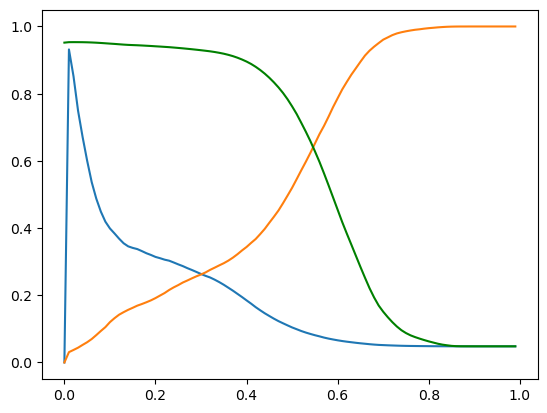

In [51]:
y_proba = model.predict_proba(x)[:,0]
thr = np.arange(0.0, 1.0, 0.01)
precision = [precision_score(y, y_proba < i) for i in thr]
recall = [recall_score(y, y_proba < i) for i in thr]
accuracy = [accuracy_score(y, y_proba < i) for i in thr]
plt.plot(thr, precision)
plt.plot(thr, recall)
plt.plot(thr, accuracy, c = 'green')

plt.show()

In [52]:
class Classifier:
    def __init__(self, model, threshold=0.5):
        self.model=model
        self.threshold=threshold
    def fit(self, x, y):
        self.model.fit(x, y)
    def predict(self, x):
        return self.model.predict_proba(x)[:,0] < self.threshold

In [53]:
pd.DataFrame(model.coef_, columns=x_train_c_piped.columns).T

,0
fps_mean,-1.206601
fps_std,0.985882
fps_lags,8.601436
rtt_mean,1.949377
rtt_std,0.876651
dropped_frames_std,0.640114
auto_bitrate_state,0.270619
auto_fec_state,1.730978
auto_fec_mean,0.650586
dropped_frames_occured,0.760957


In [83]:
threshold = 0.54

#x = x_train_c_batch_1.drop("stream_quality", axis=1)
#y = x_train_c_batch_1["stream_quality"]

x = x_train_c_piped
y = y_train_c

models = {
    "Logistic_l1" : Classifier(LogisticRegression(penalty="l1", max_iter=200, class_weight='balanced', solver="saga"), threshold=0.55),
    "Logistic_l2" : Classifier(LogisticRegression(penalty="l2", max_iter=1000, class_weight='balanced'), threshold),
    "Ridge" : RidgeClassifier(max_iter=100, class_weight='balanced'),
    "Polynomial_d2" : Polynomial(2, model=Classifier(LogisticRegression(max_iter=300, class_weight='balanced'), threshold)),
    "Polynomial_d3" : Polynomial(3, model=Classifier(LogisticRegression(max_iter=300, class_weight='balanced'), threshold))
}

metrics = {
    "accuracy_score" : lambda x, y: accuracy_score(x, y),
    "precision_score" : lambda x, y: precision_score(x, y, average = "weighted"),
    "recall_score" : lambda x, y: recall_score(x, y, average = "weighted"),
    "f1_score" : lambda x, y: f1_score(x, y, average = "weighted")
}

x_test_c_piped, y_test_c_piped = class_pipe(x_test_c.drop("stream_quality", axis=1), x_test_c["stream_quality"])

print("Train data")
for n in models:
    print(f'{n} :\n{evaluate_model(models[n], x, y, x_train_c_piped, y_train_c, fit_model=True, metrics=metrics)[0]}')

print("\nTest data")
for n in models:
    print(f'{n} :\n{np.round(evaluate_model(models[n], None, None, x_test_c_piped, y_test_c_piped, fit_model=False, metrics=metrics)[0],4)}')



#plot_confusion_matrix(y_train_c, out[2])

Train data


TypeError: accuracy_score() got an unexpected keyword argument 'average'

In [ ]:
plot_dataset(x_train_c_piped, y_train_c)

In [ ]:
plot_boxplots(x_train_c_piped)

In [ ]:
x_train_c_piped["fps_lags"].value_counts()